In [2]:
import os
import zipfile
import subprocess
import shutil

# Step 1: Set Kaggle API Key location
kaggle_json_path = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_json_path, exist_ok=True)

# NOTE: Adjust this if your kaggle.json is in the notebook folder
local_kaggle_json = "kaggle.json"

if not os.path.exists(local_kaggle_json):
    raise FileNotFoundError("⚠️ kaggle.json not found in the notebook directory!")

# Move kaggle.json to ~/.kaggle and set permissions
shutil.copy(local_kaggle_json, os.path.join(kaggle_json_path, "kaggle.json"))
os.chmod(os.path.join(kaggle_json_path, "kaggle.json"), 0o600)

# Step 2: Create data directory
data_path = "../data/breakhis"  # Going one level up from notebooks/
os.makedirs(data_path, exist_ok=True)

# Step 3: Run Kaggle CLI to download and unzip
subprocess.run([
    "kaggle", "datasets", "download",
    "-d", "ambarish/breakhis",
    "-p", data_path,
    "--unzip"
], check=True)


Dataset URL: https://www.kaggle.com/datasets/ambarish/breakhis
License(s): unknown


KeyboardInterrupt: 

In [2]:
import os
import pandas as pd
from glob import glob

# Set dataset root path
dataset_root = "../data/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast"

# Sanity check
if not os.path.exists(dataset_root):
    raise FileNotFoundError(f"❌ Dataset path not found: {dataset_root}")

# Get all image paths (recursive across magnifications)
image_paths = glob(os.path.join(dataset_root, "*", "*", "*", "*", "*", "*.png"))
print(f"🔍 Found {len(image_paths)} .png files")


# Parse image paths to extract metadata
data = []

for path in image_paths:
    parts = path.split(os.sep)
    try:
        label_type = parts[-6]         # 'malignant' or 'benign'
        subclass = parts[-4]           # e.g. 'mucinous_carcinoma'
        magnification = parts[-2]      # e.g. '100X'
        filename = os.path.basename(path)

        data.append({
            "path": path,
            "label_type": label_type,
            "subclass": subclass,
            "magnification": magnification,
            "filename": filename
        })
    except IndexError:
        print(f"❗ Skipping malformed path: {path}")

# Convert to DataFrame
metadata = pd.DataFrame(data)

# Display basic metadata
print("\n✅ Sample entries:")
print(metadata.head())

print("\n📊 Subclass distribution:")
print(metadata["subclass"].value_counts())

print("\n🔬 Magnification distribution:")
print(metadata["magnification"].value_counts())

print("\n🏷️ Label type distribution:")
print(metadata["label_type"].value_counts())


🔍 Found 7909 .png files

✅ Sample entries:
                                                path label_type  \
0  ../data/breakhis/BreaKHis_v1/BreaKHis_v1/histo...  malignant   
1  ../data/breakhis/BreaKHis_v1/BreaKHis_v1/histo...  malignant   
2  ../data/breakhis/BreaKHis_v1/BreaKHis_v1/histo...  malignant   
3  ../data/breakhis/BreaKHis_v1/BreaKHis_v1/histo...  malignant   
4  ../data/breakhis/BreaKHis_v1/BreaKHis_v1/histo...  malignant   

             subclass magnification                         filename  
0  mucinous_carcinoma          100X  SOB_M_MC-14-13418DE-100-009.png  
1  mucinous_carcinoma          100X  SOB_M_MC-14-13418DE-100-008.png  
2  mucinous_carcinoma          100X  SOB_M_MC-14-13418DE-100-003.png  
3  mucinous_carcinoma          100X  SOB_M_MC-14-13418DE-100-002.png  
4  mucinous_carcinoma          100X  SOB_M_MC-14-13418DE-100-014.png  

📊 Subclass distribution:
subclass
ductal_carcinoma       3451
fibroadenoma           1014
mucinous_carcinoma      792
lobular_c

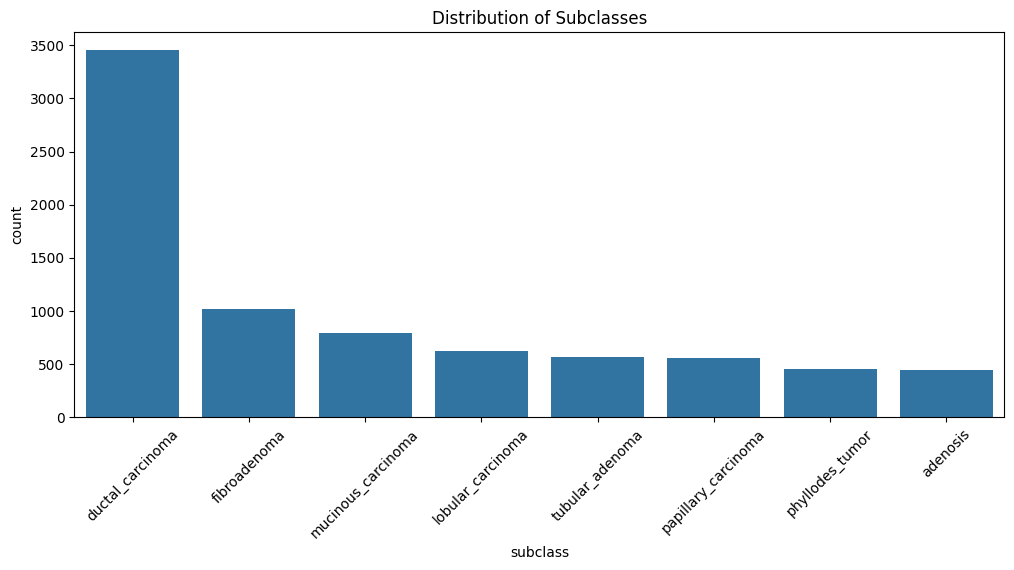

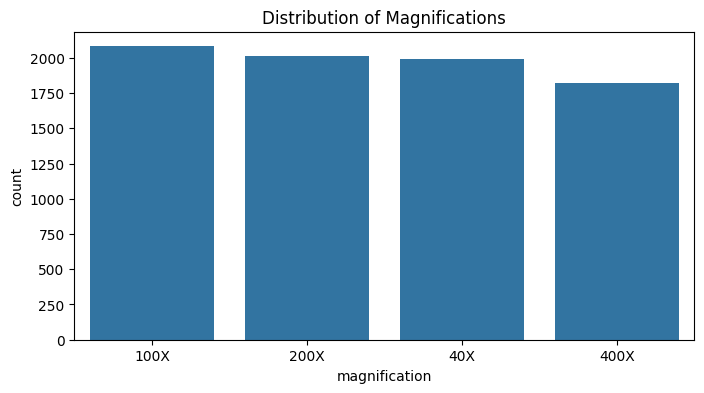

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot subclass distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=metadata, x="subclass", order=metadata["subclass"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Distribution of Subclasses")
plt.show()

# Plot magnification distribution
plt.figure(figsize=(8, 4))
sns.countplot(data=metadata, x="magnification", order=metadata["magnification"].value_counts().index)
plt.title("Distribution of Magnifications")
plt.show()


In [4]:
from sklearn.model_selection import train_test_split

# Extract patient ID
def extract_patient_id(path):
    filename = os.path.basename(path)
    return filename.split("_")[2]

metadata["patient_id"] = metadata["path"].apply(extract_patient_id)

# Get unique patient per subclass
unique_patients = metadata[["patient_id", "subclass"]].drop_duplicates()

# Train-test-val split (stratified on subclass)
train_ids, test_ids = train_test_split(
    unique_patients,
    test_size=0.15,
    stratify=unique_patients["subclass"],
    random_state=42
)

train_ids, val_ids = train_test_split(
    train_ids,
    test_size=0.15 / 0.85,
    stratify=train_ids["subclass"],
    random_state=42
)

# Map to full metadata
train_df = metadata[metadata["patient_id"].isin(train_ids["patient_id"])]
val_df = metadata[metadata["patient_id"].isin(val_ids["patient_id"])]
test_df = metadata[metadata["patient_id"].isin(test_ids["patient_id"])]
